In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#78ccdb ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >Table of Contents</h2> 


*  [1. Introduction](#1.0)
*  [2. importing libraries](#2.0)
*  [3. Data visualization](#3.0)
*  [4. Classification with Vanila CNN](#4.0)
*  [5. Data agumentaion, learning rate schedule, and Early stoping](#5.0)
*  [6. Classification with ResNet](#6.0)
*  [7. Final predictions on Test Set](#7.0)
*  [8. Summary](#8.0)


<br>
<br>
<center><h2 style = "font-family: garamond; font-size: 50px; font-style: normal; letter-spcaing: 3px; background-color:#78ccdb ; color :black; border-radius: 5px 5px; padding:10px;text-align:center; font-weight: bold" >CAT OR DOG</h2> 
<br> 
<br>
<center><div class = 'image'> <img style="float:center; border:10px solid #78ccdb; width:60%" align=center src = https://th.bing.com/th/id/OIP.hJxaRY8ee56icejxgpomYwAAAA?w=237&h=158&c=7&r=0&o=5&dpr=1.3&pid=1.7> 
</div></center>
<br>
<br>
<a href ="https://th.bing.com/th/id/OIP.hJxaRY8ee56icejxgpomYwAAAA?w=237&h=158&c=7&r=0&o=5&dpr=1.3&pid=1.7" style = "font-size:20px,color: dimgrey, text-align:left,font-family:serif"></a>
<br>


<a id = '1.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#78ccdb ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" > introduction </h2> 

# 1.0 Convolutional Neural Network (CNN)

A **Convolutional Neural Network (ConvNet/CNN)** is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

![CNN](https://i.imgur.com/jmV3oAz.jpg)

<a id = '1.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#78ccdb ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" > importing libraries </h2> 

In [2]:
import numpy as np
import sys
import tensorflow as tf
import os
import sys
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# basic librareis
import zipfile
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image


# plotting and visualizations
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import missingno as msno
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import itertools
import plotly.express as px

In [3]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [4]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [5]:
IMAGE_FOLDER_PATH = "../working/train"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)


In [6]:
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [7]:
dataset.head()


,image_path,target
0,../working/train/cat.5573.jpg,cat
1,../working/train/cat.9640.jpg,cat
2,../working/train/cat.1436.jpg,cat
3,../working/train/cat.3240.jpg,cat
4,../working/train/dog.9897.jpg,dog


In [8]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
cat    12500
dog    12500
Name: target, dtype: int64


In [9]:
fig=px.pie(counts.head(10),values= 'target', names=dataset['target'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Data',font_size=15,title_x=0.45,annotations=[dict(text='Cat vs Dog',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

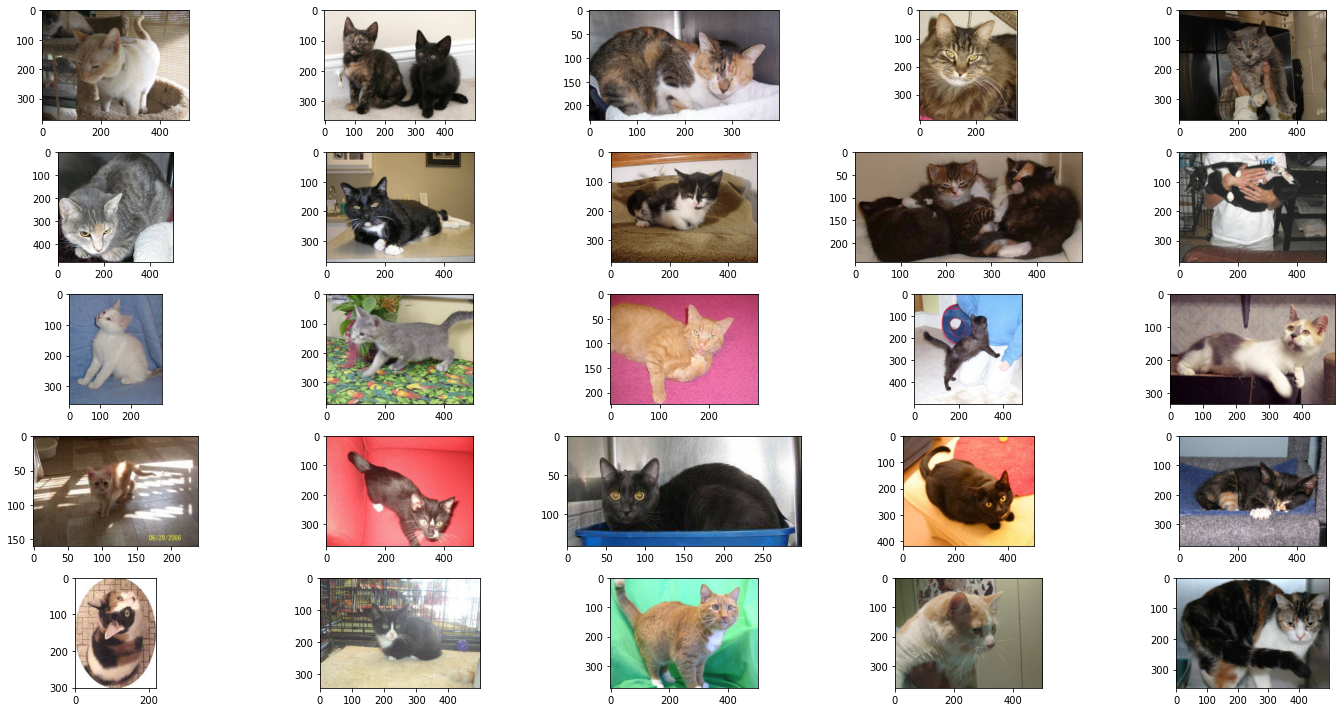

In [10]:
rows = 5
cols = 5
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = img.imread(train_cats_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

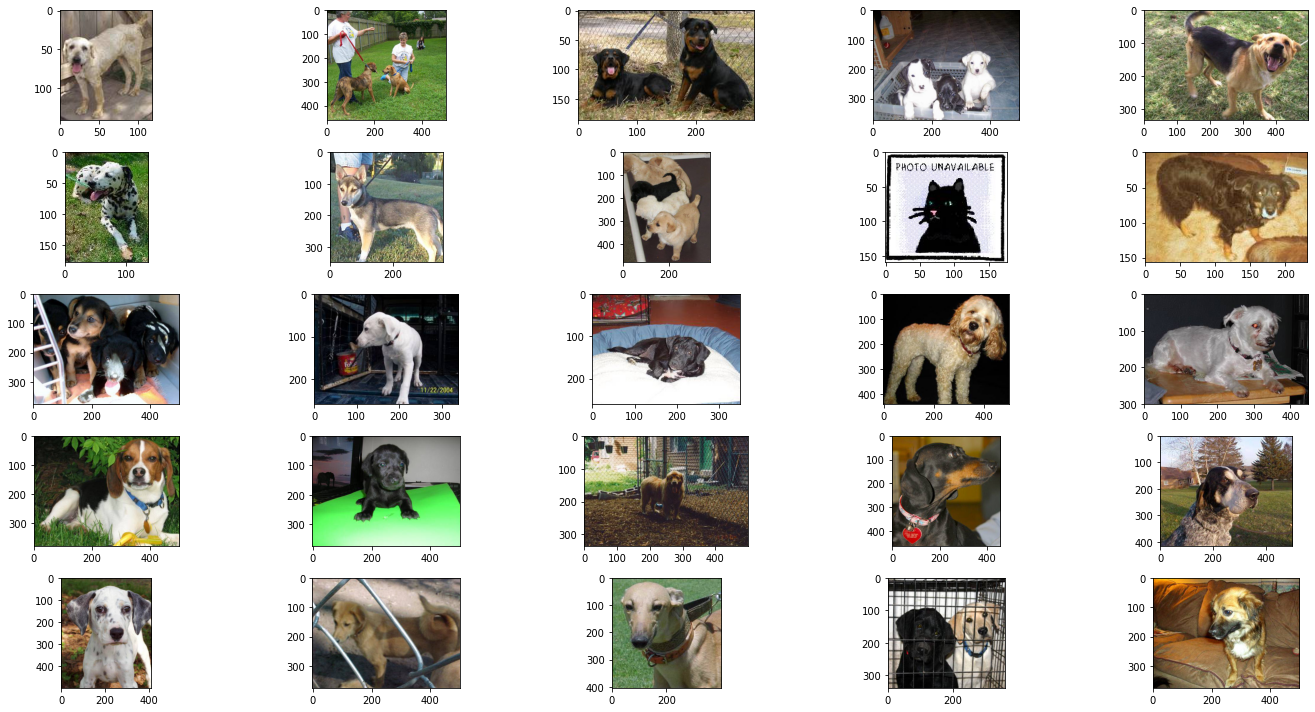

In [11]:
rows = 5
cols = 5
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = img.imread(train_dogs_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

In [12]:
train, test_val = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=20)
test, val = train_test_split(test_val, test_size=0.5,  stratify=test_val['target'], random_state=20)

In [13]:
train.shape, test_val.shape


((20000, 2), (5000, 2))

In [14]:
target_distribution =test['target'].value_counts()
target_distribution.head(10)

cat    1250
dog    1250
Name: target, dtype: int64

In [15]:
print('train set distribution:\n',train['target'].value_counts())
print('\nvalid set distribution:\n',test['target'].value_counts())
print()

plt.figure(figsize=(10,5))
fig=px.pie(target_distribution.head(10),values= 'target', names=train['target'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Train Data in Pie Chart',font_size=15,title_x=0.45,annotations=[dict(text='Cat vs Dog',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

fig=px.pie(target_distribution.head(10),values= 'target', names=test['target'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Train Data in Pie Chart',font_size=15,title_x=0.45,annotations=[dict(text='Cat vs Dog',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()


train set distribution:
 dog    10000
cat    10000
Name: target, dtype: int64

valid set distribution:
 cat    1250
dog    1250
Name: target, dtype: int64



<Figure size 720x360 with 0 Axes>

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator



In [17]:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 15

In [18]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (INPUT_SIZE,INPUT_SIZE,3),kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE,MAXPOOL_SIZE)))

model.add(Conv2D(32,(3,3), input_shape = (INPUT_SIZE,INPUT_SIZE,3),kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE,MAXPOOL_SIZE)))


model.add(Flatten())
model.add(Dense(units=128,activation ='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

aug_gen = ImageDataGenerator(rescale = 1./255)
                               
                             
training_set = aug_gen.flow_from_dataframe(train, x_col="image_path",
                                                     y_col="target",target_size = (32,32),
                                                          batch_size = 16,class_mode='binary')
# Preprocessing the Test set
test_data_generator = ImageDataGenerator(rescale = 1./255)
test_set = test_data_generator.flow_from_dataframe(test,x_col="image_path",
                                                     y_col="target",target_size = (32, 32),
                                            batch_size = 16,
                                            class_mode = 'binary')
                                           
model.summary()


2022-10-27 13:21:45.888633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 13:21:45.893089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 13:21:45.893925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 13:21:45.895122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

In [20]:
r=model.fit(x=training_set,validation_data =test_set,steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose = 1,callbacks=callbacks)


2022-10-27 13:21:49.933047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-10-27 13:21:51.421017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 64s 46ms/step - loss: 0.7081 - accuracy: 0.5434 - val_loss: 0.6795 - val_accuracy: 0.5676
Epoch 2/15
1250/1250 [==============================] - 57s 46ms/step - loss: 0.6761 - accuracy: 0.5789 - val_loss: 0.6659 - val_accuracy: 0.6032
Epoch 3/15
1250/1250 [==============================] - 56s 45ms/step - loss: 0.6684 - accuracy: 0.5968 - val_loss: 0.6613 - val_accuracy: 0.6032
Epoch 4/15
1250/1250 [==============================] - 57s 46ms/step - loss: 0.6648 - accuracy: 0.6012 - val_loss: 0.6629 - val_accuracy: 0.5936
Epoch 5/15
1250/1250 [==============================] - 57s 45ms/step - loss: 0.6605 - accuracy: 0.6053 - val_loss: 0.6519 - val_accuracy: 0.6136
Epoch 6/15
1250/1250 [==============================] - 56s 45ms/step - loss: 0.6571 - accuracy: 0.6115 - val_loss: 0.6476 - val_accuracy: 0.6124
Epoch 7/15
1250/1250 [==============================] - 57s 45ms/step - loss: 0.6545 - accuracy: 0.6176 - val_loss: 0.6457 - val_accura

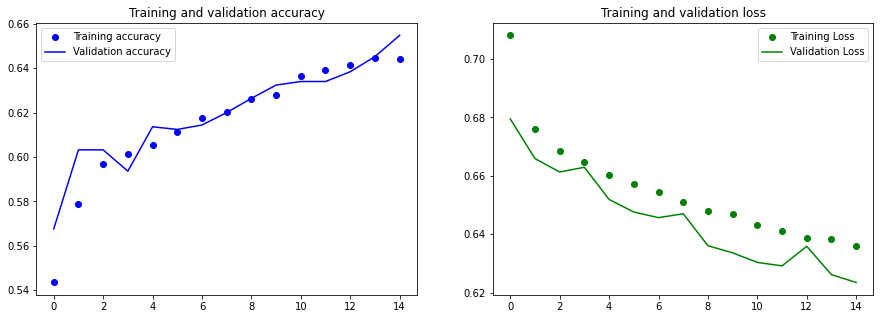

In [21]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**using SVM**

In [22]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_dataframe(train, x_col="image_path",
                                                     y_col="target",
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_dataframe(test, x_col="image_path",
                                                     y_col="target",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))
cnn.summary()

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0       

In [23]:
 #Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 20)

Epoch 1/20
625/625 [==============================] - 78s 124ms/step - loss: 0.8441 - accuracy: 0.5935 - val_loss: 0.6931 - val_accuracy: 0.6860
Epoch 2/20
625/625 [==============================] - 77s 124ms/step - loss: 0.6502 - accuracy: 0.6948 - val_loss: 0.6550 - val_accuracy: 0.7380
Epoch 3/20
625/625 [==============================] - 79s 126ms/step - loss: 0.5804 - accuracy: 0.7286 - val_loss: 0.5163 - val_accuracy: 0.7660
Epoch 4/20
625/625 [==============================] - 78s 125ms/step - loss: 0.5378 - accuracy: 0.7515 - val_loss: 0.4911 - val_accuracy: 0.7848
Epoch 5/20
625/625 [==============================] - 79s 126ms/step - loss: 0.4982 - accuracy: 0.7696 - val_loss: 0.4713 - val_accuracy: 0.7824
Epoch 6/20
625/625 [==============================] - 78s 124ms/step - loss: 0.4836 - accuracy: 0.7770 - val_loss: 0.4707 - val_accuracy: 0.8124
Epoch 7/20
625/625 [==============================] - 78s 124ms/step - loss: 0.4624 - accuracy: 0.7860 - val_loss: 0.4587 - val_ac

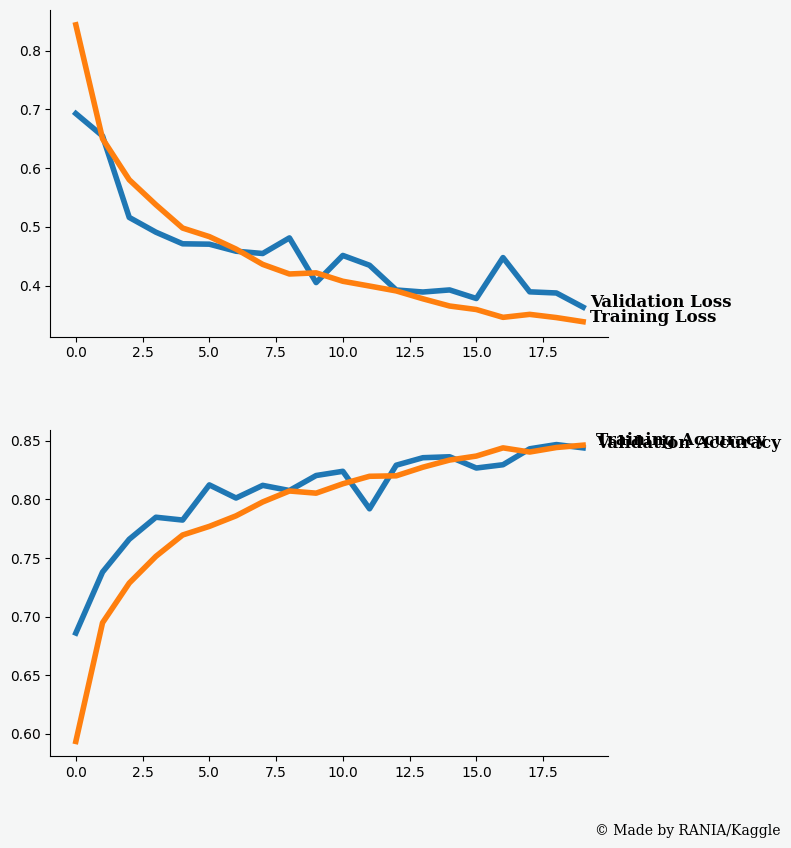

In [24]:
import seaborn as sns
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist1 = r.history
Epochs =  range(len(hist1['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist1['val_loss'],  ax = axes[0], linewidth = 4)
sns.lineplot(x = Epochs, y = hist1['loss'], ax  = axes[0], linewidth =4)


axes[0].text(Epochs[-1]+0.25,hist1['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':"black"})
axes[0].text(Epochs[-1]+0.25,hist1['loss'][-1] ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':"black"})


# accuracy plot
sns.lineplot(x = Epochs, y = hist1['val_accuracy'],ax = axes[1],linewidth = 4)
sns.lineplot(x = Epochs, y = hist1['accuracy'],ax = axes[1],linewidth =4)
axes[1].text(Epochs[-1]+0.50,hist1['val_accuracy'][-1],'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':"black"})
axes[1].text(Epochs[-1]+0.50,hist1['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':"black"})



        
fig.text(0.75,-0.05,'© Made by RANIA/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.tight_layout(h_pad = 5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00


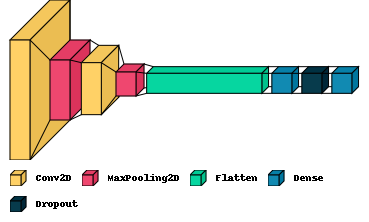

In [25]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

<a id = '5.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#78ccdb ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >Data Agumentation</h2> 

In [26]:
def data_argumentation_show(n, grid_size):
    sample_aug_map = ImageDataGenerator(
            #zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255)
    sample_data = sample_aug_map.flow_from_dataframe(
            (train_df.sample(n)),
           
            x_col = 'image_path',
            y_col = 'target',
            target_size = (img_size, img_size),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()

     


In [27]:
data_argumentation_show(1, 5)

NameError: name 'train_df' is not defined

In [ ]:
data_argumentation_show(3, 5)